### 静态网格 -- 不平仓

策略逻辑：
- 假设初始资金量为w0，网格数量为n_grid，网格距离为d_grid，maker交易手续费为tx
- 初始每个网格, limit单的资金量为 w0/n_grid
- 根据当前1分钟的close价格（c_t0），设置网格【上下摆limit单】
- 下1分钟的close(c_t1)和c_t0之间的limit单，视为成交
- 记录当前仓位w_t1，每一次价格变化，网格重新发生变化。
- 不平仓


In [1]:
import os 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from IPython.utils import io
from functions_processing_data import get_data
# from bt_grid import * 
from bt_grid_static import * 
# from bt_grid_noprint import * 

In [2]:
file_name = "binance_futures_BTCUSDT_20200101_20220322.csv"
file_name = "binance_futures_ETHUSDT_20200101_20220322.csv"
# file_name = "binance_futures_BTCUSDT_20220329_tick.csv"
df_data = get_data(file_name)
# df_data = df_data.loc[df_data.index > pd.to_datetime("2021/6/1"), :].iloc[:100]

In [3]:
df_data = df_data.loc[df_data.index > pd.to_datetime("2021/6/1"), :]
df_data

,open,high,low,close,volume
Time,,,,,
2021-06-01 00:01:00,2691.21,2708.63,2691.00,2701.50,7702.178
2021-06-01 00:02:00,2701.36,2726.46,2700.61,2725.61,9776.178
2021-06-01 00:03:00,2725.60,2732.20,2718.22,2726.29,9142.454
2021-06-01 00:04:00,2726.29,2727.60,2718.28,2725.76,3869.100
2021-06-01 00:05:00,2725.63,2732.90,2719.57,2732.01,5242.163
...,...,...,...,...,...
2022-03-21 23:56:00,2895.10,2895.66,2894.61,2895.65,68.776
2022-03-21 23:57:00,2895.65,2896.00,2894.12,2894.72,264.211
2022-03-21 23:58:00,2894.63,2894.63,2894.24,2894.45,89.504


In [4]:
# df_data.close.to_csv("ETHUSDT.csv")

In [2]:
file_name = "binance_futures_BTCUSDT_20220329_tick.csv"
file_name = "binance_futures_BTCUSDT_20220405_tick.csv"
# file_name = "binance_futures_XRPUSDT_20220405_tick.csv"
data_path = os.path.join(os.getcwd(), "data")
df_data = pd.read_csv(
            os.path.join(data_path, file_name), header=[0], index_col=[0]
        )
df_data.index = pd.to_datetime(df_data.index, unit="s")
df_data.rename(
            columns={
                "Time": "time",
                "Open": "open",
                "High": "high",
                "Close": "close",
                "Low": "low",
                "Volume": "volume",
                "price": "close",
            },
            inplace=True,
        )
df_data

,close,size,is_buyer_maker
time_seconds,,,
2022-04-05 00:00:00.068999936,46581.0,0.055,0
2022-04-05 00:00:00.109999872,46580.9,0.040,1
2022-04-05 00:00:00.109999872,46581.0,0.086,0
2022-04-05 00:00:00.122999808,46580.9,0.040,1
2022-04-05 00:00:00.147000064,46581.0,0.004,0
...,...,...,...
2022-04-05 23:59:59.588999936,45476.6,0.002,0
2022-04-05 23:59:59.588999936,45476.7,0.259,0
2022-04-05 23:59:59.611000064,45477.3,0.001,0


In [5]:
# 策略参数
w0 = 0
r = 0.003
n_grid = 50
tp = "arth"
# price_precision = 4
price_precision = 1
price_precision = 2

# test 
static_grid_bt = StaticGridBT(
    w0,
    r,
    n_grid,
    tp,
    df_data.close,
    is_trading_even=False,
    tx_m=-0.0001,
    tx_t=-0.0001,
    grid_quantity=0.001,
    price_precision=price_precision
)

print(static_grid_bt.current_grid)

# static_grid_bt.run_on_bar()

with io.capture_output() as captured: # this will supress (e.g. capture) stdout and stderr
    static_grid_bt.run_on_bar()
static_grid_bt.plot_results()
static_grid_bt.wealth.iloc[-1]

# [46441.7 46447.3 46452.8 46458.4 46464.  46469.6 46475.2 46480.7 46486.3
#  46491.9 46497.5 46503.1 46508.7 46514.2 46519.8 46525.4 46531.  46536.6
#  46542.1 46547.7 46553.3 46558.9 46564.5 46570.  46575.6 46581.2 46586.8
#  46592.4 46598.  46603.5 46609.1 46614.7 46620.3 46625.9 46631.4 46637.
#  46642.6 46648.2 46653.8 46659.3 46664.9 46670.5 46676.1 46681.7 46687.3
#  46692.8 46698.4 46704.  46709.6 46715.2 46720.7]


[2693.4 2693.7 2694.  2694.4 2694.7 2695.  2695.3 2695.7 2696.  2696.3
 2696.6 2697.  2697.3 2697.6 2697.9 2698.3 2698.6 2698.9 2699.2 2699.6
 2699.9 2700.2 2700.5 2700.9 2701.2 2701.5 2701.8 2702.1 2702.5 2702.8
 2703.1 2703.4 2703.8 2704.1 2704.4 2704.7 2705.1 2705.4 2705.7 2706.
 2706.4 2706.7 2707.  2707.3 2707.7 2708.  2708.3 2708.6 2709.  2709.3
 2709.6]


KeyboardInterrupt: 

[37061.3 37065.8 37070.2 37074.7 37079.1 37083.6 37088.  37092.5 37096.9
 37101.4 37105.8 37110.3 37114.8 37119.2 37123.7 37128.1 37132.6 37137.
 37141.5 37145.9 37150.4 37154.8 37159.3 37163.7 37168.2 37172.7 37177.1
 37181.6 37186.  37190.5 37194.9 37199.4 37203.8 37208.3 37212.7 37217.2
 37221.7 37226.1 37230.6 37235.  37239.5 37243.9 37248.4 37252.8 37257.3
 37261.7 37266.2 37270.6 37275.1 37279.6 37284. ]
[4.5 4.4 4.5 4.4 4.5 4.4 4.5 4.4 4.5 4.4 4.5 4.5 4.4 4.5 4.4 4.5 4.4 4.5
 4.4 4.5 4.4 4.5 4.4 4.5 4.5 4.4 4.5 4.4 4.5 4.4 4.5 4.4 4.5 4.4 4.5 4.5
 4.4 4.5 4.4 4.5 4.4 4.5 4.4 4.5 4.4 4.5 4.4 4.5 4.5 4.4]


36994.390627703

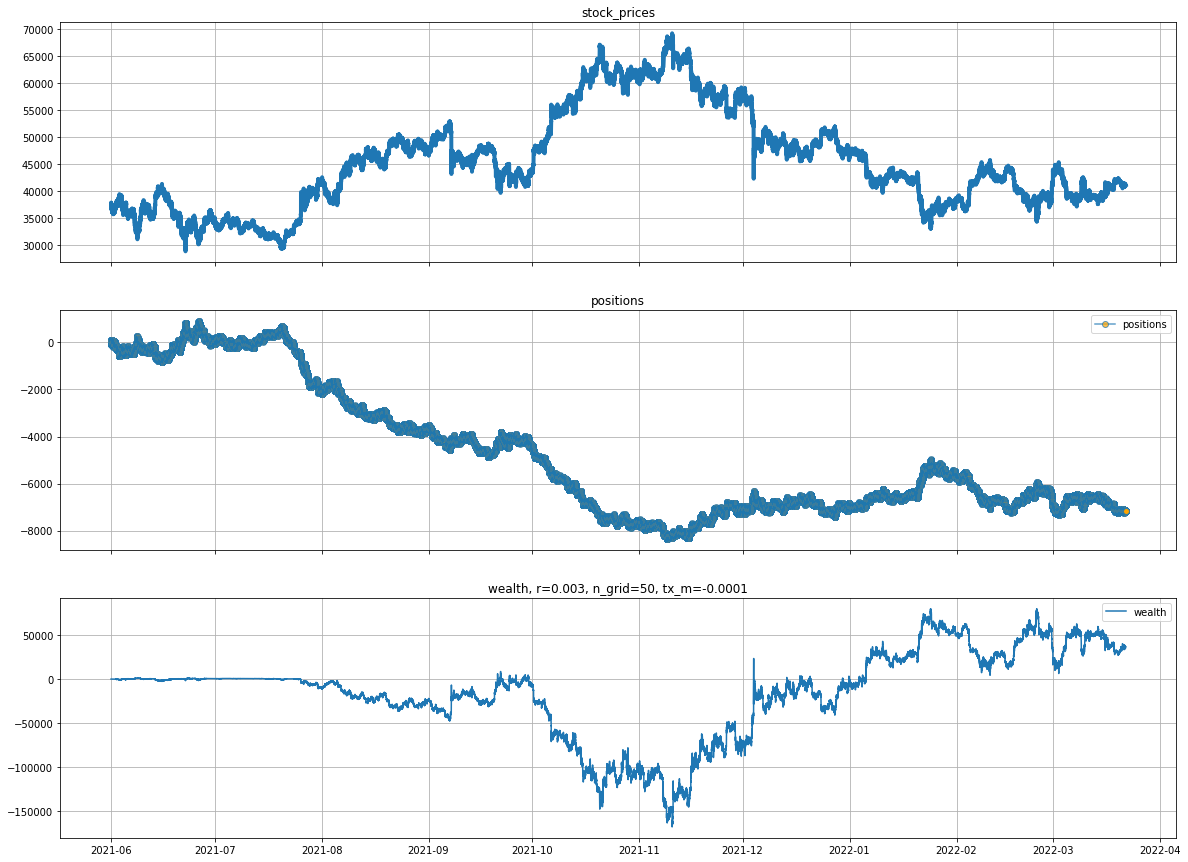

In [ ]:
# 策略参数
w0 = 0
r = 0.003
n_grid = 50
tp = "geom"
# price_precision = 4
price_precision = 1
price_precision = 2

# test 
static_grid_bt = StaticGridBT(
    w0,
    r,
    n_grid,
    tp,
    df_data.close,
    is_trading_even=False,
    tx_m=-0.0001,
    tx_t=-0.0001,
    grid_quantity=0.001,
    price_precision=price_precision
)

print(static_grid_bt.current_grid)
print(
    np.round(
        [
            static_grid_bt.current_grid[i + 1] - static_grid_bt.current_grid[i]
            for i in range(len(static_grid_bt.current_grid) - 1)
        ],
        price_precision,
    )
)

# static_grid_bt.run_on_bar()

with io.capture_output() as captured: # this will supress (e.g. capture) stdout and stderr
    static_grid_bt.run_on_bar()
static_grid_bt.plot_results()
static_grid_bt.wealth.iloc[-1]




In [15]:
# static_grid_bt.wealth.diff(1)

(static_grid_bt.wealth.iloc[-1] / static_grid_bt.wealth.diff(1).std()) 

141.43629353715303

In [21]:
(static_grid_bt.positions.abs() * static_grid_bt.stock_prices * static_grid_bt.grid_quantity).max()

575576.0662400001

[46441.7 46447.3 46452.8 46458.4 46464.  46469.6 46475.2 46480.7 46486.3
 46491.9 46497.5 46503.1 46508.7 46514.2 46519.8 46525.4 46531.  46536.6
 46542.1 46547.7 46553.3 46558.9 46564.5 46570.  46575.6 46581.2 46586.8
 46592.4 46598.  46603.5 46609.1 46614.7 46620.3 46625.9 46631.4 46637.
 46642.6 46648.2 46653.8 46659.3 46664.9 46670.5 46676.1 46681.7 46687.3
 46692.8 46698.4 46704.  46709.6 46715.2 46720.7]
[5.6 5.5 5.6 5.6 5.6 5.6 5.5 5.6 5.6 5.6 5.6 5.6 5.5 5.6 5.6 5.6 5.6 5.5
 5.6 5.6 5.6 5.6 5.5 5.6 5.6 5.6 5.6 5.6 5.5 5.6 5.6 5.6 5.6 5.5 5.6 5.6
 5.6 5.6 5.5 5.6 5.6 5.6 5.6 5.6 5.5 5.6 5.6 5.6 5.6 5.5]


348.13445511999686

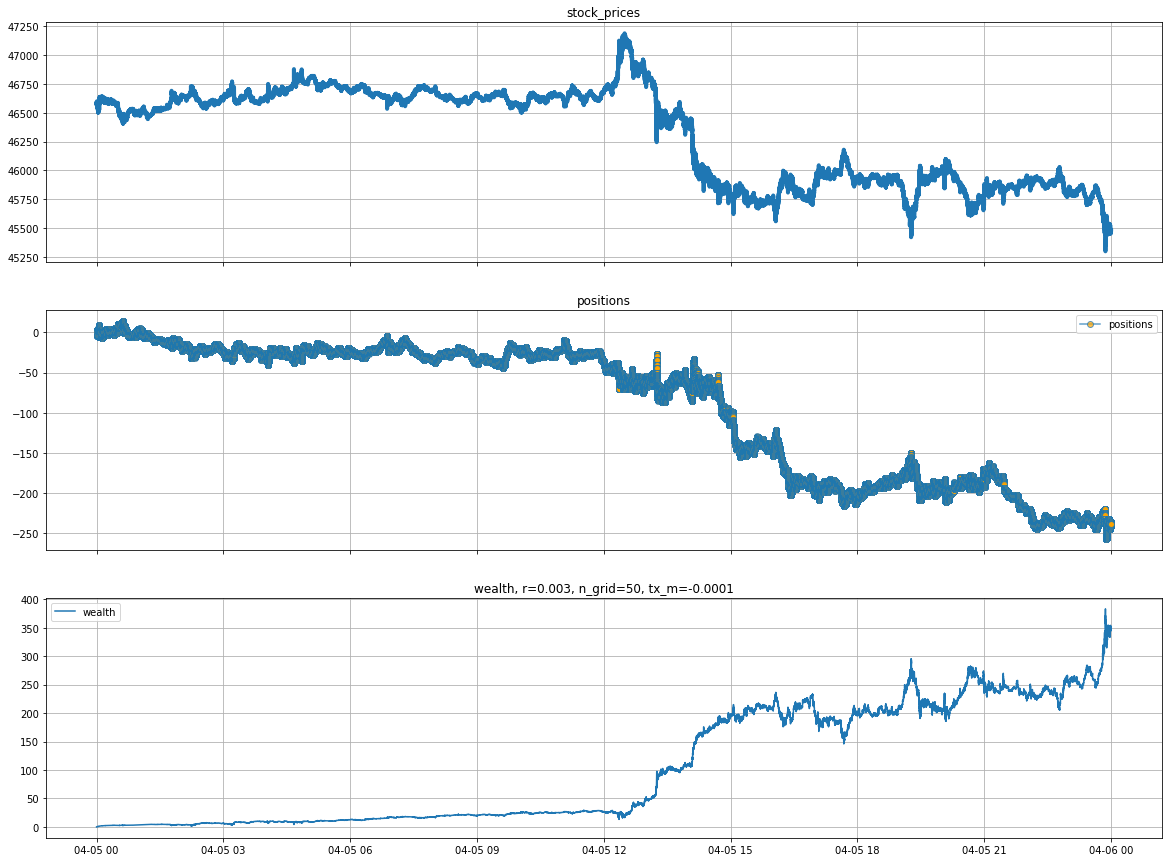

In [12]:
# 策略参数
w0 = 0
r = 0.003
n_grid = 50
tp = "geom"
# price_precision = 1

# test 
static_grid_bt = StaticGridBT(
    w0,
    r,
    n_grid,
    tp,
    df_data.close,
    is_trading_even=False,
    tx_m=-0.0001,
    tx_t=-0.0001,
    grid_quantity=0.001,
    price_precision=price_precision
)

print(static_grid_bt.current_grid)
print(
    np.round(
        [
            static_grid_bt.current_grid[i + 1] - static_grid_bt.current_grid[i]
            for i in range(len(static_grid_bt.current_grid) - 1)
        ],
        price_precision,
    )
)

with io.capture_output() as captured: # this will supress (e.g. capture) stdout and stderr
    static_grid_bt.run_on_bar()
static_grid_bt.plot_results()
static_grid_bt.wealth.iloc[-1]